## Two-dimensional projectile motion with quadratic drag

In this notebook, I will be considering the numerical solution to the equations of motion concerning the 2D trajectory of a projectile moving through a medium that exerts a quadratic drag force on it. For such a situation, we can express Newton's laws of motion as: 

\begin{align*}
\mathbf{F} = m\ddot{\mathbf{x}} = m \dot{\mathbf{v}} = 
\begin{bmatrix}
-\beta v v_x \\
-mg -\beta v v_y
\end{bmatrix}
\end{align*}

where $v = v(v_x, v_y) = \sqrt{v_x^2+v_y^2}$, $\beta$ is the quadratic drag coefficient, $g$ is the gravitational constant, and $m$ is the mass of the system. This is a first order coupled differential equation, with $\dot{v}_x = f(v_x, v_y, t)$ and $\dot{v}_y = g(v_x, v_y, t)$.

To solve this, we can define the state function $\mathbf{f}$


\begin{align*}
\mathbf{f}(v_x, v_y, t) = 
\begin{bmatrix}
f(v_x, v_y, t) \\
g(v_x, v_y, t)
\end{bmatrix}
=
\begin{bmatrix}
-\frac{\beta}{m} \sqrt{v_x^2+v_y^2} v_x \\
-g -\frac{\beta}{m} \sqrt{v_x^2+v_y^2} v_y
\end{bmatrix}
\end{align*}

This function can then be fed into our scipy.integrate.ivp_solve function in order to solve for the velocity.

Finally, to get the position $\mathbf{x}(t)$, we can integrate our velocity:

\begin{align*}
\mathbf{x}(t) = \int_{t_0}^t \mathbf{v}(t') dt' \simeq 
\sum_{i = 1}^N \mathbf{v}_i \Delta t_i
\end{align*}

In the last step, we express the computed velocities as $\mathbf{v}_i = \begin{bmatrix} v_{xi} \\ v_yi \end{bmatrix}$ determined at each time-step $\Delta t_i$ from our Runge Kutta method. This integral can be computed using a cumulative trapezoidal or cumulative Simpsom algorithm from scipy.integrate.

In [1]:
import numpy as np
import sympy as sp
import scipy as sc
import matplotlib.pyplot as plt
import ipywidgets as wd
import matplotlib.animation as animation
%matplotlib widget

In [ ]:
def stateFunction(t, vstar, beta, g, m):
    vx, vy = vstar # unpack the state vector components
    vxDot = -(beta/m)*np.sqrt(vx**2 + vy**2)*vx #calculate derivative in x
    vyDot = -g - (beta/m)*np.sqrt(vx**2 + vy**2)*vy # calculate derivative in y 
    return [vxDot, vyDot] #return answer as list

def integrateVelocity(t, vel, r0):
    x0, y0 = r0 #unpack initial position
    vx, vy = vel #unpack velocity array

    #integrate the velocity wrt time to determine position
    xOfT = sc.integrate.cumulative_simpson(vx, x=t, initial=x0)
    yOfT = sc.integrate.cumulative_simpson(vy, x=t, initial=y0)

    return [xOfT, yOfT] #return answer as list

def solve(t, fun, q0, args):
    #args contains the coefficients for the state function 
    
    #qstar needs to be the function that determines the derivative (stateFunction above)
    t_span = (t[0], t[-1]) #define the range of time based on t array
    #numerically solve given initial conditions 
    sol = sc.integrate.solve_ivp(fun, t_span, q0,
                                 method='RK45', t_eval=t,
                                 args=args)
    
    solution = [t] #create a list for the solution
    #unpack the solution vector to return as a tuple
    for y in sol.y:
        solution.append(y)
    
    return solution


C:\Users\lucas\AppData\Local\Temp\ipykernel_10020\1757072637.py:53: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


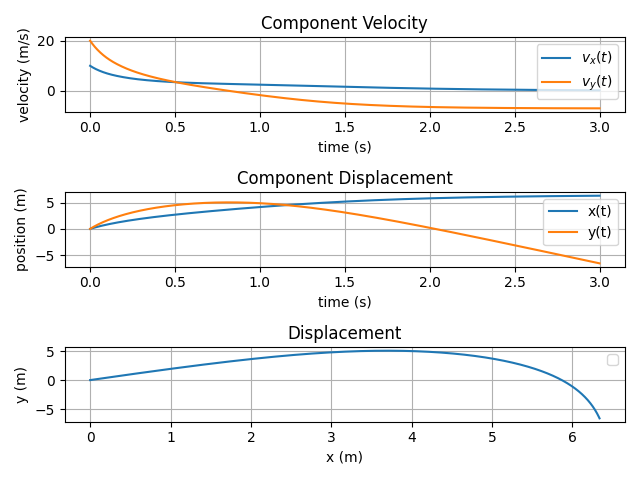

In [11]:
g = 9.8 #m/s2 define gravity
beta = 0.2 #Ns2/m4 order of magnitude given by Taylor book
m = 1 #mass of the system in kg

args = [beta, g, m] #coefficients for state function
v0 = [10, 100] #m/s, initial component velocity, vx,vy
r0 = [0, 0] # m, initial position x, y

N = 10000 #number of time steps
#start and end times
tStart = 0
tEnd = 3
v0 = [10, 20]
t = np.linspace(tStart, tEnd, N)

_, vx, vy  = solve(t, stateFunction, v0, args) #no need for the time

#velocity vectors
v = [vx, vy]

#integrate velocity to get positions
xoft, yoft = integrateVelocity(t, v, r0)


#graph
fig, ax = plt.subplots(3,1)

ax[0].plot(t, vx, label='$v_x(t)$')
ax[0].plot(t, vy, label='$v_y(t)$')

ax[0].set_title('Component Velocity')
ax[0].set_ylabel('velocity (m/s)')
ax[0].set_xlabel('time (s)')

ax[1].plot(t, xoft, label="x(t)")
ax[1].plot(t, yoft, label="y(t)")

ax[1].set_title('Component Displacement')
ax[1].set_ylabel('position (m)')
ax[1].set_xlabel('time (s)')

ax[2].plot(xoft, yoft)
ax[2].set_title('Displacement')
ax[2].set_ylabel('y (m)')
ax[2].set_xlabel('x (m)')

ax[0].legend()
ax[1].legend()

for a in ax:
    a.grid()
    
plt.legend()
fig.tight_layout()
plt.show()

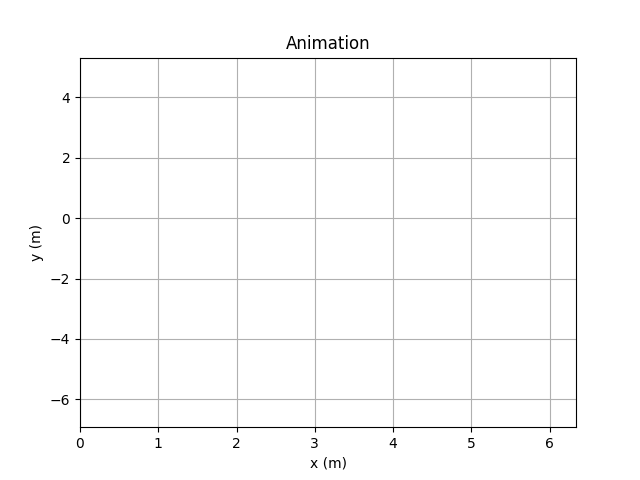

In [18]:
fig = plt.figure()

ax = fig.add_subplot(autoscale_on=False, xlim=(xoft[0], xoft[-1]),
                     ylim=(1.05*min(yoft), 1.05*max(yoft)))

#empty line
line, = ax.plot([], [], 'o-')
#trace, = ax.plot()
dt = t[1]-t[0]
#time_template = 'time = %.1dt*1000fs'
time_text = ax.text(0.05, 0.9, '', transform=ax.transAxes)

ax.set_ylabel('y (m)')
ax.set_xlabel('x (m)')
ax.set_title('Animation')
ax.grid()
xframe = []
yframe = []

#capture every other 100 step to animate
for i in range(len(xoft)):
    if i % 100 == 0:
        xframe.append(xoft[i])
        yframe.append(yoft[i])
    else:
        continue

#create function for empty list before animating, 
#important when rerunning the code
def init():
    thisx = []
    thisy = []
    return

def animate(i):
    #reset list
    init()

    #set the x,y coordinates to animate
    thisx = [xframe[i]]
    thisy = [yframe[i]]
    
    #plot
    line.set_data(thisx, thisy)
    #time_text.set_text(time_template % (i*dt))
    
    return line#, time_text

ani = animation.FuncAnimation(
    fig, animate, len(t), blit=True
)

plt.show()

In [5]:
1/24

0.041666666666666664